In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import pandas as pd

Load the dataset

In [2]:
df = pd.read_csv('../data/StudentPerformanceFactors.csv')
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


Preprocessing

In [3]:
df.columns = df.columns.str.lower()

In [4]:
categorical = df.dtypes[df.dtypes == 'object'].index.to_list()
categorical

['parental_involvement',
 'access_to_resources',
 'extracurricular_activities',
 'motivation_level',
 'internet_access',
 'family_income',
 'teacher_quality',
 'school_type',
 'peer_influence',
 'learning_disabilities',
 'parental_education_level',
 'distance_from_home',
 'gender']

In [5]:
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_').str.strip()

df.head()

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,low,high,no,7,73,low,yes,0,low,medium,public,positive,3,no,high_school,near,male,67
1,19,64,low,medium,no,8,59,low,yes,2,medium,medium,public,negative,4,no,college,moderate,female,61
2,24,98,medium,medium,yes,7,91,medium,yes,2,medium,medium,public,neutral,4,no,postgraduate,near,male,74
3,29,89,low,medium,yes,8,98,medium,yes,1,medium,medium,public,negative,4,no,high_school,moderate,male,71
4,19,92,medium,medium,yes,6,65,medium,yes,3,medium,high,public,neutral,4,no,college,near,female,70


Exploratory data analysis (EDA)

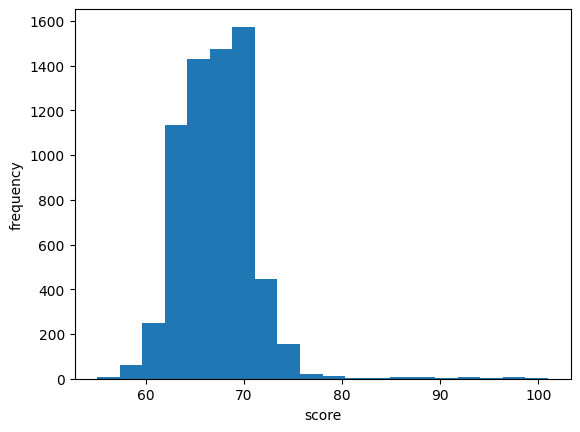

In [6]:
# Distribution of exam_score
plt.hist(df['exam_score'], bins=20)

plt.xlabel('score')
plt.ylabel('frequency')

plt.show()

In [7]:
# Columns with NaN values
df.isna().sum()[df.isna().sum() > 0]

teacher_quality             78
parental_education_level    90
distance_from_home          67
dtype: int64

In [8]:
# Size and % of records with NaN data
nan_records = int(((df['teacher_quality'].isna()) | (df['parental_education_level'].isna()) | (df['distance_from_home'].isna())).sum())
nan_records, nan_records/len(df)

(229, 0.03466020886938096)

In [9]:
for col in categorical:
    if df[col].isna().sum() > 0:
        print(col)
        mean_scores = df.groupby(col)['exam_score'].mean().sort_values()
        print(mean_scores)
        print()

teacher_quality
teacher_quality
low       66.753425
medium    67.109299
high      67.676939
Name: exam_score, dtype: float64

parental_education_level
parental_education_level
high_school     66.893577
college         67.315737
postgraduate    67.970881
Name: exam_score, dtype: float64

distance_from_home
distance_from_home
far         66.457447
moderate    66.981481
near        67.512101
Name: exam_score, dtype: float64



In [10]:
# FaFrom your visualization, the mean exam scores for each teacher_quality level (low, medium, high) are very close to one another — all around 67–68. That tells us that this feature currently has little to no differentiating power on exam score (at least in the mean).

# Given that:

# The differences between categories are all around between 66-68, and
# Only ~3.5% of records are missing,

# It’s perfectly reasonable (and safe) to replace the NaN values with "Unknown" in this case.

In [11]:
# Replace NaN with "Unknown"
df = df.fillna('Unknown')

Setting up the validation framework

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(3963, 1322, 1322)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train['exam_score']
y_val = df_val['exam_score']
y_test = df_test['exam_score']

del df_train['exam_score']
del df_val['exam_score']
del df_test['exam_score']

Feature importance

a. Average ratio

In [16]:
average_score = df_full_train['exam_score'].mean()

In [17]:
from IPython.display import display

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c)['exam_score'].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - average_score
    df_group['ratio'] = df_group['mean'] / average_score
    display(df_group)
    print()
    print()



parental_involvement


,mean,count,diff,ratio
parental_involvement,,,,
high,68.036482,1535,0.823048,1.012245
low,66.366572,1053,-0.846863,0.987400
medium,67.075640,2697,-0.137795,0.997950




access_to_resources


,mean,count,diff,ratio
access_to_resources,,,,
high,68.097423,1591,0.883989,1.013152
low,66.108238,1044,-1.105197,0.983557
medium,67.118113,2650,-0.095321,0.998582




extracurricular_activities


,mean,count,diff,ratio
extracurricular_activities,,,,
no,66.925151,2151,-0.288283,0.995711
yes,67.411295,3134,0.197861,1.002944




motivation_level


,mean,count,diff,ratio
motivation_level,,,,
high,67.679317,1054,0.465883,1.006931
low,66.733770,1525,-0.479664,0.992864
medium,67.302291,2706,0.088857,1.001322




internet_access


,mean,count,diff,ratio
internet_access,,,,
no,66.600522,383,-0.612912,0.990881
yes,67.261322,4902,0.047888,1.000712




family_income


,mean,count,diff,ratio
family_income,,,,
high,67.777007,1009,0.563573,1.008385
low,66.868039,2137,-0.345395,0.994861
medium,67.292660,2139,0.079226,1.001179




teacher_quality


,mean,count,diff,ratio
teacher_quality,,,,
Unknown,66.683333,60,-0.530101,0.992113
high,67.657809,1543,0.444375,1.006611
low,66.847358,511,-0.366076,0.994554
medium,67.066225,3171,-0.147209,0.997810




school_type


,mean,count,diff,ratio
school_type,,,,
private,67.221255,1609,0.007821,1.000116
public,67.210011,3676,-0.003423,0.999949




peer_influence


,mean,count,diff,ratio
peer_influence,,,,
negative,66.484959,1097,-0.728475,0.989162
neutral,67.175904,2075,-0.037531,0.999442
positive,67.628490,2113,0.415056,1.006175




learning_disabilities


,mean,count,diff,ratio
learning_disabilities,,,,
no,67.331919,4712,0.118484,1.001763
yes,66.239092,573,-0.974342,0.985504




parental_education_level


,mean,count,diff,ratio
parental_education_level,,,,
Unknown,67.105263,76,-0.108171,0.998391
college,67.275510,1568,0.062076,1.000924
high_school,66.866821,2598,-0.346614,0.994843
postgraduate,67.991371,1043,0.777937,1.011574




distance_from_home


,mean,count,diff,ratio
distance_from_home,,,,
Unknown,66.942308,52,-0.271127,0.995966
far,66.405204,538,-0.808230,0.987975
moderate,66.956767,1596,-0.256667,0.996181
near,67.490481,3099,0.277047,1.004122




gender


,mean,count,diff,ratio
gender,,,,
female,67.243207,2245,0.029773,1.000443
male,67.191447,3040,-0.021987,0.999673


b. Mutual information

In [18]:
from sklearn.metrics import mutual_info_score

In [19]:
def mutual_info_exam_score(series):
    return mutual_info_score(series, df_full_train['exam_score'])

In [20]:
mi = df_full_train[categorical].apply(mutual_info_exam_score)
mi.sort_values(ascending=False)

access_to_resources           0.031334
parental_involvement          0.024040
parental_education_level      0.019952
peer_influence                0.015808
distance_from_home            0.015224
family_income                 0.013029
motivation_level              0.012871
teacher_quality               0.011500
learning_disabilities         0.009849
extracurricular_activities    0.006475
gender                        0.006432
internet_access               0.005734
school_type                   0.004405
dtype: float64

c. Correlation

In [21]:
numerical = [x for x in df_full_train.columns if x not in categorical + ['exam_score']]
numerical

['hours_studied',
 'attendance',
 'sleep_hours',
 'previous_scores',
 'tutoring_sessions',
 'physical_activity']

In [22]:
df_full_train[numerical].corrwith(df_full_train['exam_score']).abs().sort_values(ascending=False)

attendance           0.583230
hours_studied        0.444993
previous_scores      0.170288
tutoring_sessions    0.144915
physical_activity    0.025132
sleep_hours          0.014007
dtype: float64

One-hot encoding

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_full_train = df_full_train['exam_score']


Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [27]:
y_pred = lr_model.predict(X_val)
lr_rmse = root_mean_squared_error(y_val, y_pred)
lr_rmse

2.474972372447616

In [28]:
student = df_test.loc[15].to_dict()

X_student = dv.transform(student)
predicted_score = lr_model.predict(X_student)
y_test[15], predicted_score

(np.int64(62), array([61.78745469]))

Decision Tree Regressor

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
scores = []

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dtr_model = DecisionTreeRegressor(max_depth=d, random_state=1)
    dtr_model.fit(X_train, y_train)
    y_pred = dtr_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append((d, score))

In [31]:
columns = ['max_depth', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

,max_depth,score
5,6.0,3.041906
4,5.0,3.046507
3,4.0,3.116423
2,3.0,3.229160
1,2.0,3.334505


In [32]:
max_depth = 6

In [33]:
scores = []
for d in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 100, 200, 500]:
        dtr_model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=1)
        dtr_model.fit(X_train, y_train)
        y_pred = dtr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)
        scores.append((d, s, score))

In [34]:
pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'score']).sort_values(by='score').head(10)

,max_depth,min_samples_leaf,score
20,6,20,3.023211
17,6,5,3.023931
19,6,15,3.024266
18,6,10,3.025773
21,6,100,3.037629
16,6,1,3.041906
13,5,100,3.042119
9,5,5,3.046507
8,5,1,3.046507
11,5,15,3.046507


In [35]:
max_depth = 6
min_samples_leaf = 20

In [36]:
dtr_model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
dtr_model.fit(X_train, y_train)
y_pred = dtr_model.predict(X_val)
dtr_rmse = root_mean_squared_error(y_val, y_pred)
dtr_rmse

3.0232109438477175

In [37]:
predicted_score = dtr_model.predict(X_student)
y_test[15], predicted_score

(np.int64(62), array([61.66442953]))

Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
scores = []

for n in range(10, 201, 10):
    rf_model = RandomForestRegressor(n_estimators=n, random_state=1)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    
    scores.append((n, score))

In [40]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

In [41]:
df_scores.sort_values(by='score').head()

,n_estimators,score
15,160,2.727102
14,150,2.729756
16,170,2.730430
17,180,2.731638
19,200,2.732181


In [42]:
scores = []

for d in [2, 3, 4, 5, 10, 15, None]:
    for n in range(10, 201, 10):
        rfr_model = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, score))

In [43]:
columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='score').head()

,max_depth,n_estimators,score
115,15.0,160,2.724700
135,NaN,160,2.727102
117,15.0,180,2.727394
119,15.0,200,2.728126
116,15.0,170,2.728158


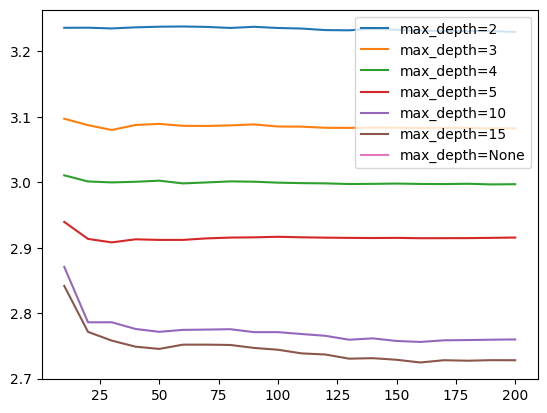

In [44]:
for d in [2, 3, 4, 5, 10, 15, None]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             label=f'max_depth={d}')

plt.legend()

In [45]:
max_depth = 15

In [46]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rfr_model = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((s, n, score))

In [47]:
columns = ['min_samples_leaf', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

,min_samples_leaf,n_estimators,score
32,3,130,2.709348
34,3,150,2.709781
39,3,200,2.709910
35,3,160,2.709932
36,3,170,2.709984


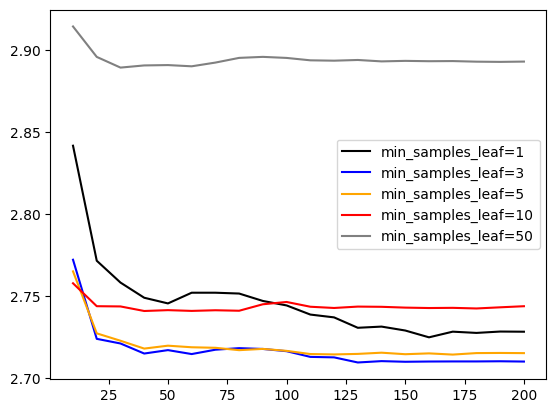

In [48]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             color=col,
             label=f'min_samples_leaf={s}')

plt.legend()

In [49]:
min_samples_leaf = 3

In [50]:
scores = []

for n in range(10, 201, 10):
    rfr_model = RandomForestRegressor(n_estimators=n,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=1)
    rfr_model.fit(X_train, y_train)

    y_pred = rfr_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)

    scores.append((n, score))

In [51]:
columns = ['n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

,n_estimators,score
12,130,2.709348
14,150,2.709781
19,200,2.709910
15,160,2.709932
16,170,2.709984


In [52]:
n_estimators = 130

In [53]:
rfr_model = RandomForestRegressor(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rfr_model.fit(X_train, y_train)

y_pred = rfr_model.predict(X_val)
rfr_score = root_mean_squared_error(y_val, y_pred)
rfr_score

2.7093483705493075

In [54]:
predicted_score = rf_model.predict(X_student)
y_test[15], predicted_score

(np.int64(62), array([62.85]))

XGBoost

In [55]:
import xgboost as xgb

In [56]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, feature_names=features)

In [57]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [58]:
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = xgb_model.predict(dval)


In [59]:
root_mean_squared_error(y_val, y_pred)

2.722395420074463

In [60]:
# XGBoost parameter tuning


In [61]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [62]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [63]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [64]:
scores = {}

In [93]:
%%capture output
eta = 1 # replace values manually for eta=0.01, eta=0.02, eta=0.05, eta=0.1, eta=0.3, eta=0.5, eta=0.8, eta=1

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}



xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2000,
                  verbose_eval=5,
                  evals=watchlist)


In [94]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

In [95]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.02', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=0.5', 'eta=0.8', 'eta=1'])

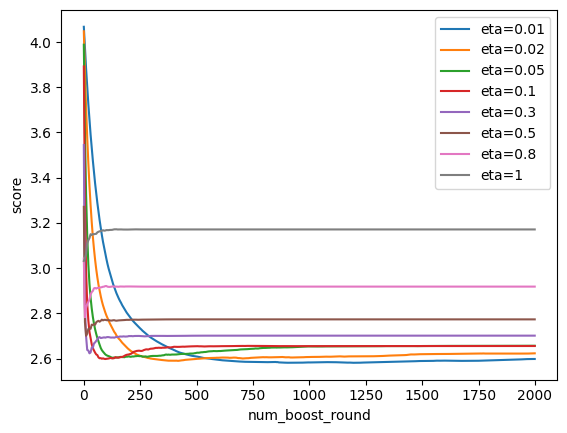

In [102]:
for eta in scores.keys():
    df_scores = scores[eta]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=eta)
plt.xlabel('num_boost_round')
plt.ylabel('score')
plt.legend()

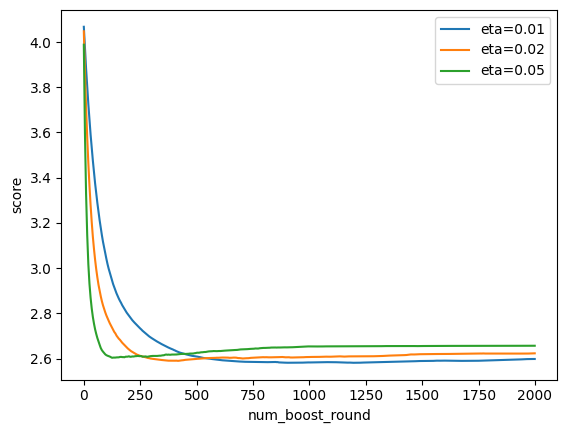

In [103]:
# Remove eta=0.1, eta=0.3, eta=0.5, eta=0.8 and eta=1 for a better visualization.
etas = [x for x in scores.keys() if x not in ['eta=0.1', 'eta=0.3', 'eta=0.5', 'eta=0.8', 'eta=1']]
for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=eta)
plt.xlabel('num_boost_round')
plt.ylabel('score')
plt.legend()

In [104]:
# Best eta after 750 n_interactions
eta = 0.01

In [105]:
scores = {}

In [122]:
%%capture output
max_depth = 10 # replace values manually for max_depth=6, max_depth=3, max_depth=4, max_depth=8, max_depth=10

xgb_params = {
    'eta': 0.01, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2500,
                  verbose_eval=5,
                  evals=watchlist)


In [123]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [124]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=8', 'max_depth=10'])

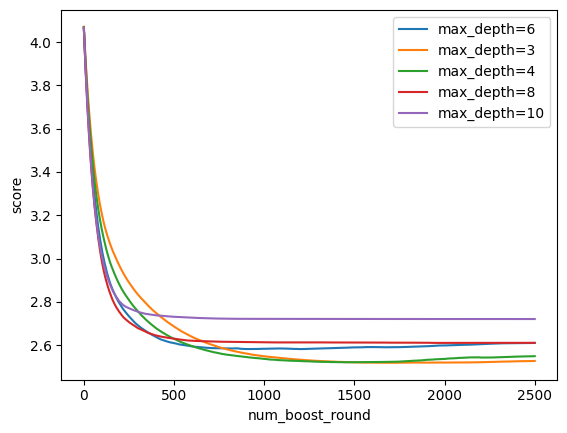

In [128]:
for max_depth in scores.keys():
    df_scores = scores[max_depth]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=max_depth)
plt.xlabel('num_boost_round')
plt.ylabel('score')
# plt.ylim(2.5, 2.7)
plt.legend()

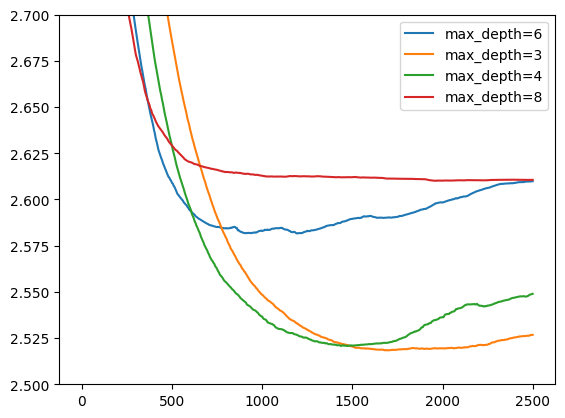

In [129]:
# Remove max_depth=10 and zoom the graph between scores of 2.5-2.7 for a better visualization.
max_depths = [x for x in scores.keys() if x not in ['max_depth=10']]
for max_depth in max_depths:
    df_scores = scores[max_depth]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=max_depth)
plt.ylim(2.5, 2.7)
plt.legend()

In [ ]:
max_depth = 3 # after num_boost_round 1500. Overfitting after 2000?

In [130]:
scores = {}

In [139]:
%%capture output
min_child_weight = 30 # replace values manually for min_child_weight=1, min_child_weight=10, min_child_weight=30

xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': min_child_weight,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2500,
                  verbose_eval=5,
                  evals=watchlist)


In [140]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [141]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

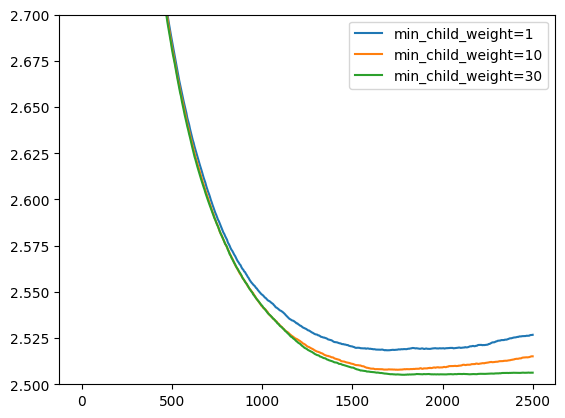

In [142]:
min_child_weights = [x for x in scores.keys() if x not in []]
for min_child_weight in min_child_weights:
    df_scores = scores[min_child_weight]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=min_child_weight)
plt.ylim(2.5, 2.7)

plt.legend()

In [143]:
min_child_weight = 30 # after aprox. 1750 num_boost_round

In [144]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=1800)


In [145]:
y_pred = xgb_model.predict(dval)

In [146]:
xgb_rmse = root_mean_squared_error(y_val, y_pred)
xgb_rmse

2.5051987171173096

In [147]:
dstudent = xgb.DMatrix(X_student, feature_names=features)
predicted_score = xgb_model.predict(dstudent)
y_test[15], predicted_score

(np.int64(62), array([62.109276], dtype=float32))

Build the final model

In [148]:
lr_rmse, dtr_rmse, rfr_score, xgb_rmse

(2.474972372447616, 3.0232109438477175, 2.7093483705493075, 2.5051987171173096)

The best is: Linear Regression Model

In [149]:
lr_model = LinearRegression()
lr_model.fit(X_full_train, y_full_train)

y_pred = lr_model.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_rmse

1.9656620650680725

In [150]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_full_train = df_full_train['exam_score']


In [151]:
df_student = df_test.iloc[52]
student_dict = df_student[categorical + numerical].to_dict()
X_student = dv.transform(student_dict)
score_prediction = lr_model.predict(X_student)
score_prediction, y_test[52]

(array([72.04512297]), np.int64(72))

Save the model

In [152]:
from sklearn.pipeline import make_pipeline

In [153]:
pipeline = make_pipeline(
    DictVectorizer(), 
    LinearRegression()
)

In [154]:
pipeline.fit(full_train_dict, y_full_train)

,steps,"[('dictvectorizer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,True
,sort,True
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [155]:
pipeline.predict(student_dict)

array([72.0452061])

In [156]:
import pickle

In [157]:
with open('model.bin', 'wb') as f_out:
    pickle.dump(pipeline, f_out)

Make prediction

In [158]:
import pickle

with open('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [159]:
student = {
    'hours_studied': 15,
    'attendance': 66,
    'parental_involvement': 'medium',
    'access_to_resources': 'low',
    'extracurricular_activities': 'yes',
    'sleep_hours': 4,
    'previous_scores': 90,
    'motivation_level': 'low',
    'internet_access': 'yes',
    'tutoring_sessions': 2,
    'family_income': 'medium',
    'teacher_quality': 'high',
    'school_type': 'public',
    'peer_influence': 'negative',
    'physical_activity': 7,
    'learning_disabilities': 'no',
    'parental_education_level': 'college',
    'distance_from_home': 'far',
    'gender': 'female'
}

pipeline.predict(student)

array([62.72703752])